In [2]:
!pip install numpy pandas matplotlib

  Using cached numpy-2.2.6-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 5.4 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached matplotlib-3.10.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pillow-11.2.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (8.9 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached numpy-2.2.6-cp313-cp313-macosx_14_0_arm64.whl (5.

In [3]:
import numpy as np
import pandas as pd
import re
from typing import List, Tuple, Dict, Optional
import math
import matplotlib.pyplot as plt

### Load Datasets

In [4]:
with open('input.txt', 'r', encoding='utf-8') as f:
    raw_text = f.read()

print(f"Raw text loaded, total characters: {len(raw_text)}")
print(f"Sample text: \n{raw_text[:200]}...")

Raw text loaded, total characters: 1052958
Sample text: 
YMCA in South Australia
South Australia (SA)  has a unique position in Australia's history as, unlike the other states which were founded as colonies, South Australia began as a self governing provinc...


### Preprocessing Text data

In [6]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s.,!?;:-]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

cleaned_text = clean_text(raw_text)

cleaned_text = cleaned_text[:5000]
print(f"Cleaned text length: {len(cleaned_text)}")
print(f"Sample cleaned text:\n{cleaned_text[:200]}...")

Cleaned text length: 5000
Sample cleaned text:
ymca in south australia south australia sa has a unique position in australias history as, unlike the other states which were founded as colonies, south australia began as a self governing province ma...


### Split into sentences

In [7]:
sentences = []

sentence_pattern = r'[.!?]+\s+'
raw_sentences = re.split(sentence_pattern, cleaned_text)

for sent in raw_sentences:
    sent = sent.strip()
    if len(sent) > 10:
        sentences.append(sent)

print(f"Total sentences: {len(sentences)}")
print(f"Average sentence length: {np.mean([len(s) for s in sentences]):.2f} characters")
print(f"Sample sentences:")

for i in range(10):
    print(f"  {i+1}: {sentences[i]}")

Total sentences: 41
Average sentence length: 119.32 characters
Sample sentences:
  1: ymca in south australia south australia sa has a unique position in australias history as, unlike the other states which were founded as colonies, south australia began as a self governing province many were attracted to this and adelaide and sa developed as an independent and free thinking state
  2: the compound of philosophical radicalism, evangelical religion and self reliant ability typical of its founders had given an equalitarian flavour to south australian thinking from the beginning
  3: it was into this social setting that in february 1850 a meeting was called primarily for the formation of an association apparently meaning a y.m.c.a
  4: for apprentices and others, after their days work, to enjoy books, lectures, discussions, readings, friendly relief and recreation for a leisure hour
  5: in september 1850 records show that this became the young mens christian association of south australi

### Prepare data for BPE Tokenzier

In [8]:
# convert sentences to word list

corpus = []
for sentence in sentences:
    word = sentence.split()
    if len(word) > 1:
        corpus.append(word)

# remove very short or very long sentences for efficiency
corpus = [sent for sent in corpus if 3 <= len(sent) <= 100]

print(f"Corpus size: {len(corpus)} sentences")
print(f"Total words: {sum(len(sent) for sent in corpus)}")
print(f"Average sentence length: {np.mean([len(sent) for sent in corpus]):.2f} words")
print(f"Sample sentences:")
for i in range(3):

    print(f"  {i+1}: {' '.join(corpus[i])}")

Corpus size: 39 sentences
Total words: 823
Average sentence length: 21.10 words
Sample sentences:
  1: ymca in south australia south australia sa has a unique position in australias history as, unlike the other states which were founded as colonies, south australia began as a self governing province many were attracted to this and adelaide and sa developed as an independent and free thinking state
  2: the compound of philosophical radicalism, evangelical religion and self reliant ability typical of its founders had given an equalitarian flavour to south australian thinking from the beginning
  3: it was into this social setting that in february 1850 a meeting was called primarily for the formation of an association apparently meaning a y.m.c.a


### Build Vocab

In [9]:
# get word tokens with f

vocab_freq = {}
for sentence in corpus:
    for word in sentence:
        chars = list(word) + ["</w>"]
        token = tuple(chars)
        vocab_freq[token] = vocab_freq.get(token, 0) + 1

print(f"Initial vocabulary size: {len(vocab_freq)}")
print(f"Most frequent tokens: {sorted(vocab_freq.items(), key=lambda x: x[1], reverse=True)[:5]}")

Initial vocabulary size: 406
Most frequent tokens: [(('t', 'h', 'e', '</w>'), 59), (('o', 'f', '</w>'), 38), (('a', 'n', 'd', '</w>'), 29), (('i', 'n', '</w>'), 27), (('a', '</w>'), 25)]


### BPE Tokenizer Training

In [10]:
def get_pairs(vocab):
    pairs = {}
    for word, freq in vocab.items():
        for i in range(len(word) - 1):
            pair = (word[i], word[i + 1])
            pairs[pair] = pairs.get(pair, 0) + freq
    return pairs

def merge_vocab(pair, vocab):
    new_vocab = {}
    bigram = ''.join(pair)
    
    for word, freq in vocab.items():
        new_word = []
        i = 0
        while i < len(word):
            if i < len(word) - 1 and (word[i], word[i + 1]) == pair:
                new_word.append(bigram)
                i += 2
            else:
                new_word.append(word[i])
                i += 1
        new_vocab[tuple(new_word)] = freq
    
    return new_vocab

# Train BPE with more merges for pretraining
num_merges = 2000  # Increased for better subword representation
merges = []
current_vocab = vocab_freq.copy()

for merge_step in range(num_merges):
    pairs = get_pairs(current_vocab)
    if not pairs:
        break
        
    best_pair = max(pairs, key=pairs.get)
    if pairs[best_pair] < 2:
        break
        
    current_vocab = merge_vocab(best_pair, current_vocab)
    merges.append(best_pair)
    
    if merge_step % 200 == 0:
        print(f"Merge step {merge_step}, vocab size: {len(current_vocab)}")

print(f"BPE training completed with {len(merges)} merges")

Merge step 0, vocab size: 406
Merge step 200, vocab size: 406
Merge step 400, vocab size: 406
BPE training completed with 433 merges


### Create Final Vocabulary

In [11]:
# Extract all unique tokens
token_set = set()
for word in current_vocab.keys():
    for token in word:
        token_set.add(token)

# Create vocabulary mapping with special tokens for language modeling
vocab = {token: idx for idx, token in enumerate(sorted(token_set))}
vocab["[UNK]"] = len(vocab)
vocab["[PAD]"] = len(vocab)
vocab["[BOS]"] = len(vocab)  # Beginning of sequence
vocab["[EOS]"] = len(vocab)  # End of sequence
vocab["[MASK]"] = len(vocab)  # For masked language modeling

vocab_size = len(vocab)
print(f"Final vocabulary size: {vocab_size}")
print(f"Special tokens: [UNK], [PAD], [BOS], [EOS], [MASK]")

Final vocabulary size: 391
Special tokens: [UNK], [PAD], [BOS], [EOS], [MASK]


### Encode Text Function

In [12]:
def encode_word(word, vocab, merges):
    tokens = list(word) + ["</w>"]
    
    # Apply learned merges
    for pair in merges:
        bigram = ''.join(pair)
        new_tokens = []
        i = 0
        while i < len(tokens):
            if i < len(tokens) - 1 and (tokens[i], tokens[i + 1]) == pair:
                new_tokens.append(bigram)
                i += 2
            else:
                new_tokens.append(tokens[i])
                i += 1
        tokens = new_tokens
    
    # Convert to IDs
    token_ids = []
    for token in tokens:
        if token in vocab:
            token_ids.append(vocab[token])
        else:
            for char in token:
                token_ids.append(vocab.get(char, vocab["[UNK]"]))
    
    return token_ids

In [13]:
def encode_corpus_for_lm(corpus, vocab, merges):
    """Encode corpus for language modeling (with BOS/EOS tokens)"""
    encoded = []
    for sentence in corpus:
        # Add BOS token at beginning, EOS at end
        encoded_sentence = [vocab["[BOS]"]]
        for word in sentence:
            encoded_sentence.extend(encode_word(word, vocab, merges))
        encoded_sentence.append(vocab["[EOS]"])
        encoded.append(encoded_sentence)
    return encoded

# Encode the corpus
encoded_corpus = encode_corpus_for_lm(corpus, vocab, merges)
print(f"Encoded corpus size: {len(encoded_corpus)}")
print(f"Sample encoded sentence: {encoded_corpus[0][:15]}...")
print(f"Average encoded length: {np.mean([len(sent) for sent in encoded_corpus]):.2f}")

Encoded corpus size: 39
Sample encoded sentence: [388, 382, 190, 311, 77, 311, 77, 299, 176, 36, 348, 285, 122, 271, 248]...
Average encoded length: 40.38


### Prepare Training Data for Language Modeling

In [14]:
# For causal language modeling, we create input-target pairs
# Input: [BOS, token1, token2, ..., tokenN]
# Target: [token1, token2, ..., tokaenN, EOS]

max_len = 128  # Maximum sequence length
min_len = 10   # Minimum sequence length

def create_lm_sequences(encoded_corpus, max_len, min_len):
    sequences = []
    targets = []
    
    for sentence in encoded_corpus:
        if len(sentence) < min_len:
            continue
            
        # If sentence is too long, split it into chunks
        if len(sentence) > max_len:
            for i in range(0, len(sentence) - max_len + 1, max_len // 2):
                chunk = sentence[i:i + max_len]
                if len(chunk) >= min_len:
                    sequences.append(chunk[:-1])  # Input (without last token)
                    targets.append(chunk[1:])     # Target (shifted by 1)
        else:
            sequences.append(sentence[:-1])  # Input (without EOS)
            targets.append(sentence[1:])     # Target (without BOS)
    
    return sequences, targets

input_sequences, target_sequences = create_lm_sequences(encoded_corpus, max_len, min_len)
print(f"Training sequences created: {len(input_sequences)}")
print(f"Sample input: {input_sequences[0][:10]}...")
print(f"Sample target: {target_sequences[0][:10]}...")

Training sequences created: 38
Sample input: [388, 382, 190, 311, 77, 311, 77, 299, 176, 36]...
Sample target: [382, 190, 311, 77, 311, 77, 299, 176, 36, 348]...


### Padding and Batching for Language Modelin

In [15]:
def pad_sequences_lm(sequences, max_len, pad_value):
    """Pad sequences for language modeling"""
    padded = []
    attention_masks = []
    
    for seq in sequences:
        if len(seq) > max_len:
            seq = seq[:max_len]
        
        # Create attention mask (1 for real tokens, 0 for padding)
        mask = [1] * len(seq) + [0] * (max_len - len(seq))
        
        # Pad sequence
        padded_seq = seq + [pad_value] * (max_len - len(seq))
        
        padded.append(padded_seq)
        attention_masks.append(mask)
    
    return np.array(padded), np.array(attention_masks)

# Pad sequences
padded_inputs, input_masks = pad_sequences_lm(input_sequences, max_len, vocab["[PAD]"])
padded_targets, target_masks = pad_sequences_lm(target_sequences, max_len, vocab["[PAD]"])

print(f"Padded inputs shape: {padded_inputs.shape}")
print(f"Padded targets shape: {padded_targets.shape}")
print(f"Input masks shape: {input_masks.shape}")

Padded inputs shape: (38, 128)
Padded targets shape: (38, 128)
Input masks shape: (38, 128)


### Model Hyperparameters for Language Modeling

In [16]:
# Model configuration
d_model = 512   # Embedding dimension (larger for pretraining)
n_heads = 8     # Number of attention heads
n_layers = 12   # Number of transformer layers (deeper for pretraining)
n_groups = 2    # Number of groups for grouped attention
head_dim = d_model // n_heads
ff_dim = d_model * 4  # Feedforward dimension

print(f"Model Configuration for Language Modeling:")
print(f"- Vocabulary size: {vocab_size}")
print(f"- Model dimension: {d_model}")
print(f"- Number of heads: {n_heads}")
print(f"- Head dimension: {head_dim}")
print(f"- Number of layers: {n_layers}")
print(f"- Feedforward dimension: {ff_dim}")
print(f"- Max sequence length: {max_len}")


Model Configuration for Language Modeling:
- Vocabulary size: 391
- Model dimension: 512
- Number of heads: 8
- Head dimension: 64
- Number of layers: 12
- Feedforward dimension: 2048
- Max sequence length: 128


### Activation Functions

In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def swish(x):
    return x * sigmoid(x)

def swiglu(x1, x2):
    return x2 * swish(x1)

def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

def rms_norm(x, gamma=1.0, eps=1e-8):
    rms = np.sqrt(np.mean(x**2, axis=-1, keepdims=True) + eps)
    return gamma * x / rms

print("Activation functions defined")

Activation functions defined


### Rotary Position Embedding (RoPE)

In [18]:
def rope(x, positions):
    """Apply Rotary Position Embedding"""
    batch_size, seq_len, d = x.shape
    result = np.zeros_like(x)

    # Pastikan positions dalam shape (seq_len,)
    positions = positions.reshape(seq_len)

    for i in range(0, d, 2):
        if i + 1 < d:
            # theta shape: (seq_len, 1)
            theta = positions[:, np.newaxis] / (10000 ** (i / d))
            cos_theta = np.cos(theta)  # (seq_len, 1)
            sin_theta = np.sin(theta)  # (seq_len, 1)

            # Broadcast ke (batch_size, seq_len)
            cos_theta = np.broadcast_to(cos_theta.T, (batch_size, seq_len))
            sin_theta = np.broadcast_to(sin_theta.T, (batch_size, seq_len))

            x0 = x[:, :, i]
            x1 = x[:, :, i + 1]

            result[:, :, i] = x0 * cos_theta - x1 * sin_theta
            result[:, :, i + 1] = x0 * sin_theta + x1 * cos_theta
        else:
            result[:, :, i] = x[:, :, i]

    return result

print("RoPE function defined")

RoPE function defined


### Multi-Head Attention with Causal Masking

In [19]:
def multi_head_attention(x, wq, wk, wv, wo, attention_mask=None, use_rope=True):
    batch_size, seq_len, d_model = x.shape
    
    # Linear projections
    Q = x @ wq.T
    K = x @ wk.T
    V = x @ wv.T
    
    # Reshape for multi-head
    Q = Q.reshape(batch_size, seq_len, n_heads, head_dim).transpose(0, 2, 1, 3)
    K = K.reshape(batch_size, seq_len, n_heads, head_dim).transpose(0, 2, 1, 3)
    V = V.reshape(batch_size, seq_len, n_heads, head_dim).transpose(0, 2, 1, 3)
    
    # Apply RoPE
    if use_rope:
        positions = np.arange(seq_len)
        for head in range(n_heads):
            Q[:, head, :, :] = rope(Q[:, head, :, :], positions)
            K[:, head, :, :] = rope(K[:, head, :, :], positions)
    
    # Attention scores
    scores = np.matmul(Q, K.transpose(0, 1, 3, 2)) / np.sqrt(head_dim)
    
    # Create causal mask (lower triangular)
    causal_mask = np.triu(np.ones((seq_len, seq_len)), k=1) * -1e9
    scores = scores + causal_mask[np.newaxis, np.newaxis, :, :]
    
    # Apply attention mask if provided
    if attention_mask is not None:
        # Convert to additive mask
        mask = (1 - attention_mask[:, np.newaxis, np.newaxis, :]) * -1e9
        scores = scores + mask
    
    # Softmax
    attn_weights = softmax(scores, axis=-1)
    
    # Apply to values
    context = np.matmul(attn_weights, V)
    
    # Concatenate heads
    context = context.transpose(0, 2, 1, 3).reshape(batch_size, seq_len, d_model)
    
    # Output projection
    output = context @ wo.T
    
    return output, attn_weights

print("Causal multi-head attention function defined")

Causal multi-head attention function defined


### Feedforward Network

In [20]:
def feedforward(x, w1, w2, w3):
    """Feedforward with SwiGLU activation"""
    gate = x @ w1      # Gate
    input_proj = x @ w2  # Input projection
    hidden = swiglu(gate, input_proj)  # SwiGLU activation
    output = hidden @ w3  # Output projection
    return output

print("Feedforward function defined")

Feedforward function defined


### Initialize Model Weights

In [21]:
def init_weights(shape, scale=0.02):
    return np.random.randn(*shape) * scale

# Embedding layer
embedding_matrix = init_weights((vocab_size, d_model))

# Transformer layers weights
attention_weights = []
ff_weights = []

for layer in range(n_layers):
    # Attention weights
    wq = init_weights((d_model, d_model))
    wk = init_weights((d_model, d_model))
    wv = init_weights((d_model, d_model))
    wo = init_weights((d_model, d_model))
    attention_weights.append((wq, wk, wv, wo))
    
    # Feedforward weights
    w1 = init_weights((d_model, ff_dim))  # Gate
    w2 = init_weights((d_model, ff_dim))  # Input
    w3 = init_weights((ff_dim, d_model))  # Output
    ff_weights.append((w1, w2, w3))

# Language modeling head (predict next token)
lm_head_weights = init_weights((d_model, vocab_size))

print(f"Model weights initialized:")
print(f"- Embedding: {embedding_matrix.shape}")
print(f"- Attention layers: {len(attention_weights)}")
print(f"- Feedforward layers: {len(ff_weights)}")
print(f"- Language modeling head: {lm_head_weights.shape}")

Model weights initialized:
- Embedding: (391, 512)
- Attention layers: 12
- Feedforward layers: 12
- Language modeling head: (512, 391)


### Feedforward Network

In [22]:
def feedforward(x, w1, w2, w3):
    """Feedforward with SwiGLU activation"""
    gate = x @ w1      # Gate
    input_proj = x @ w2  # Input projection
    hidden = swiglu(gate, input_proj)  # SwiGLU activation
    output = hidden @ w3  # Output projection
    return output

print("Feedforward function defined")

Feedforward function defined


### Initialize Model Weights

In [23]:
def init_weights(shape, scale=0.02):
    return np.random.randn(*shape) * scale

# Embedding layer
embedding_matrix = init_weights((vocab_size, d_model))

# Transformer layers weights
attention_weights = []
ff_weights = []

for layer in range(n_layers):
    # Attention weights
    wq = init_weights((d_model, d_model))
    wk = init_weights((d_model, d_model))
    wv = init_weights((d_model, d_model))
    wo = init_weights((d_model, d_model))
    attention_weights.append((wq, wk, wv, wo))
    
    # Feedforward weights
    w1 = init_weights((d_model, ff_dim))  # Gate
    w2 = init_weights((d_model, ff_dim))  # Input
    w3 = init_weights((ff_dim, d_model))  # Output
    ff_weights.append((w1, w2, w3))

# Language modeling head (predict next token)
lm_head_weights = init_weights((d_model, vocab_size))

print(f"Model weights initialized:")
print(f"- Embedding: {embedding_matrix.shape}")
print(f"- Attention layers: {len(attention_weights)}")
print(f"- Feedforward layers: {len(ff_weights)}")
print(f"- Language modeling head: {lm_head_weights.shape}")

Model weights initialized:
- Embedding: (391, 512)
- Attention layers: 12
- Feedforward layers: 12
- Language modeling head: (512, 391)


### Forward Pass for Language Modeling

In [24]:
def transformer_lm_forward(input_ids, attention_mask=None):
    batch_size, seq_len = input_ids.shape
    
    # Embedding
    x = embedding_matrix[input_ids]  # (batch, seq, d_model)
    
    # Pass through transformer layers
    for layer in range(n_layers):
        # Get layer weights
        wq, wk, wv, wo = attention_weights[layer]
        w1, w2, w3 = ff_weights[layer]
        
        # Pre-attention norm
        x_norm = rms_norm(x)
        
        # Self-attention with causal masking
        attn_out, _ = multi_head_attention(x_norm, wq, wk, wv, wo, attention_mask)
        
        # Residual connection
        x = x + attn_out
        
        # Pre-feedforward norm
        x_norm = rms_norm(x)
        
        # Feedforward
        ff_out = feedforward(x_norm, w1, w2, w3)
        
        # Residual connection
        x = x + ff_out
    
    # Final normalization
    x = rms_norm(x)
    
    # Language modeling head - predict next tokens
    logits = x @ lm_head_weights  # (batch, seq, vocab_size)
    
    return logits

print("Language modeling forward pass function defined")

Language modeling forward pass function defined


### Loss Function for Language Modeling

In [25]:
def language_modeling_loss(logits, targets, target_mask):
    """Cross entropy loss for language modeling"""
    batch_size, seq_len, vocab_size = logits.shape
    
    # Flatten for easier computation
    logits_flat = logits.reshape(-1, vocab_size)
    targets_flat = targets.reshape(-1)
    mask_flat = target_mask.reshape(-1)
    
    # Only compute loss for non-padded tokens
    valid_indices = mask_flat == 1
    
    if np.sum(valid_indices) == 0:
        return 0.0, np.zeros_like(logits_flat)
    
    valid_logits = logits_flat[valid_indices]
    valid_targets = targets_flat[valid_indices]
    
    # Softmax
    probs = softmax(valid_logits, axis=-1)
    probs = np.clip(probs, 1e-12, 1 - 1e-12)
    
    # Cross entropy
    loss = -np.mean(np.log(probs[np.arange(len(valid_targets)), valid_targets]))
    
    return loss, probs

def perplexity(loss):
    """Calculate perplexity from loss"""
    return np.exp(loss)

print("Language modeling loss functions defined")

Language modeling loss functions defined


### Data Splitting for Pretraining

In [26]:
# Split data into train/validation
split_idx = int(0.9 * len(padded_inputs))  # Use more data for training in pretraining

train_inputs = padded_inputs[:split_idx]
train_targets = padded_targets[:split_idx]
train_masks = input_masks[:split_idx]

val_inputs = padded_inputs[split_idx:]
val_targets = padded_targets[split_idx:]
val_masks = input_masks[split_idx:]

print(f"Training data: {train_inputs.shape[0]} sequences")
print(f"Validation data: {val_inputs.shape[0]} sequences")
print(f"Total tokens in training: {np.sum(train_masks)}")

# ===== CELL 21: Training Setup for Language Modeling =====
# Training hyperparameters
learning_rate = 0.0001  # Lower learning rate for pretraining
batch_size = 8          # Smaller batch size due to memory constraints
num_epochs = 5          # Fewer epochs for demo

def create_batches(inputs, targets, masks, batch_size):
    n_samples = inputs.shape[0]
    indices = np.random.permutation(n_samples)
    
    batches = []
    for i in range(0, n_samples, batch_size):
        batch_indices = indices[i:i+batch_size]
        batch_inputs = inputs[batch_indices]
        batch_targets = targets[batch_indices]
        batch_masks = masks[batch_indices]
        batches.append((batch_inputs, batch_targets, batch_masks))
    
    return batches

print(f"Training setup for language modeling:")
print(f"- Learning rate: {learning_rate}")
print(f"- Batch size: {batch_size}")
print(f"- Epochs: {num_epochs}")
print(f"- Batches per epoch: {len(train_inputs) // batch_size}")

Training data: 34 sequences
Validation data: 4 sequences
Total tokens in training: 1441
Training setup for language modeling:
- Learning rate: 0.0001
- Batch size: 8
- Epochs: 5
- Batches per epoch: 4


### Training Loop for Language Modeling

In [27]:
train_losses = []
val_losses = []
train_perplexities = []
val_perplexities = []

print("Starting language model pretraining...")

for epoch in range(num_epochs):
    # Training
    train_batches = create_batches(train_inputs, train_targets, train_masks, batch_size)
    
    epoch_train_loss = 0
    
    for batch_idx, (batch_inputs, batch_targets, batch_masks) in enumerate(train_batches):
        # Forward pass
        logits = transformer_lm_forward(batch_inputs, batch_masks)
        
        # Compute loss
        loss, _ = language_modeling_loss(logits, batch_targets, batch_masks)
        epoch_train_loss += loss
        
        if batch_idx % 20 == 0:
            ppl = perplexity(loss)
            print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss:.4f}, Perplexity: {ppl:.2f}")
    
    # Average training metrics
    avg_train_loss = epoch_train_loss / len(train_batches)
    train_ppl = perplexity(avg_train_loss)
    
    # Validation
    val_logits = transformer_lm_forward(val_inputs, val_masks)
    val_loss, _ = language_modeling_loss(val_logits, val_targets, val_masks)
    val_ppl = perplexity(val_loss)
    
    # Store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    train_perplexities.append(train_ppl)
    val_perplexities.append(val_ppl)
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Perplexity: {train_ppl:.2f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Perplexity: {val_ppl:.2f}")
    print("-" * 60)

print("Language model pretraining completed!")

Starting language model pretraining...
Epoch 1, Batch 0, Loss: 6.0960, Perplexity: 444.06
Epoch 1/5:
  Train Loss: 6.1051, Train Perplexity: 448.13
  Val Loss: 6.1393, Val Perplexity: 463.74
------------------------------------------------------------
Epoch 2, Batch 0, Loss: 6.1392, Perplexity: 463.66
Epoch 2/5:
  Train Loss: 6.1065, Train Perplexity: 448.78
  Val Loss: 6.1393, Val Perplexity: 463.74
------------------------------------------------------------
Epoch 3, Batch 0, Loss: 6.0905, Perplexity: 441.62
Epoch 3/5:
  Train Loss: 6.1127, Train Perplexity: 451.56
  Val Loss: 6.1393, Val Perplexity: 463.74
------------------------------------------------------------
Epoch 4, Batch 0, Loss: 6.1139, Perplexity: 452.08
Epoch 4/5:
  Train Loss: 6.1113, Train Perplexity: 450.93
  Val Loss: 6.1393, Val Perplexity: 463.74
------------------------------------------------------------
Epoch 5, Batch 0, Loss: 6.1062, Perplexity: 448.65
Epoch 5/5:
  Train Loss: 6.1271, Train Perplexity: 458.10


### Plot Training Results

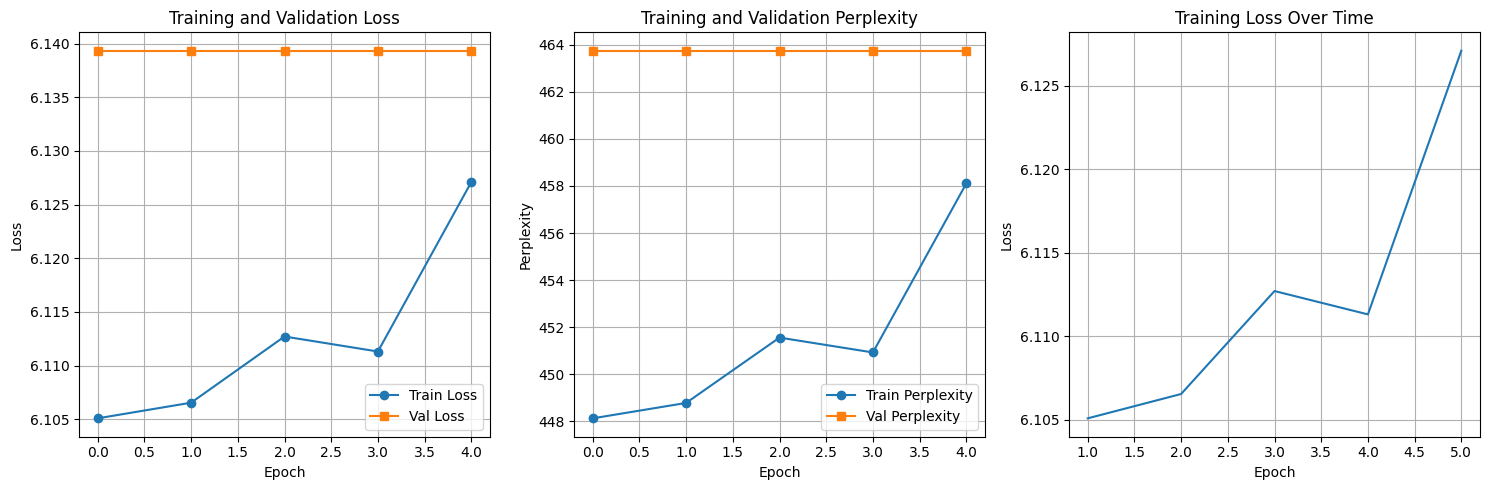

Final Results:
- Final Train Perplexity: 458.10
- Final Validation Perplexity: 463.74
- Best Validation Perplexity: 463.74


In [28]:
plt.figure(figsize=(15, 5))

# Plot losses
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='s')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot perplexities
plt.subplot(1, 3, 2)
plt.plot(train_perplexities, label='Train Perplexity', marker='o')
plt.plot(val_perplexities, label='Val Perplexity', marker='s')
plt.title('Training and Validation Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()
plt.grid(True)

# Plot learning curve
plt.subplot(1, 3, 3)
plt.plot(range(1, len(train_losses) + 1), train_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Results:")
print(f"- Final Train Perplexity: {train_perplexities[-1]:.2f}")
print(f"- Final Validation Perplexity: {val_perplexities[-1]:.2f}")
print(f"- Best Validation Perplexity: {min(val_perplexities):.2f}")

### Text Generation Function

In [29]:
def generate_text(prompt, max_length=50, temperature=1.0):
    """Generate text using the trained language model"""
    # Encode prompt
    words = prompt.lower().split()
    prompt_tokens = [vocab["[BOS]"]]
    for word in words:
        prompt_tokens.extend(encode_word(word, vocab, merges))
    
    generated_tokens = prompt_tokens.copy()
    
    for _ in range(max_length):
        # Prepare input (last max_len tokens)
        input_tokens = generated_tokens[-max_len:]
        input_array = np.array([input_tokens + [vocab["[PAD]"]] * (max_len - len(input_tokens))])
        attention_mask = np.array([([1] * len(input_tokens) + [0] * (max_len - len(input_tokens)))])
        
        # Forward pass
        logits = transformer_lm_forward(input_array, attention_mask)
        
        # Get logits for next token (last non-padded position)
        next_token_logits = logits[0, len(input_tokens) - 1, :] / temperature
        
        # Sample next token
        probs = softmax(next_token_logits)
        next_token = np.random.choice(vocab_size, p=probs)
        
        # Stop if EOS token
        if next_token == vocab["[EOS]"]:
            break
            
        generated_tokens.append(next_token)
    
    # Decode tokens back to text (simplified)
    reverse_vocab = {v: k for k, v in vocab.items()}
    generated_text = []
    
    for token_id in generated_tokens[len(prompt_tokens):]:
        if token_id in reverse_vocab:
            token = reverse_vocab[token_id]
            if token not in ["[BOS]", "[EOS]", "[PAD]", "[UNK]"]:
                generated_text.append(token.replace("</w>", " "))
    
    return "".join(generated_text).strip()

In [ ]:
# Test text generation
test_prompts = [
    "the weather is",
    "i think that",
    "machine learning"
]

print("Testing text generation:")
for prompt in test_prompts:
    generated = generate_text(prompt, max_length=20, temperature=0.8)
    print(f"Prompt: '{prompt}'")
    print(f"Generated: '{generated}'")
    print("-" * 40)

Testing text generation:
Prompt: 'the weather is'
Generated: 'ods attracted one not ali6 mecallour ymca yhiing tilealisofrom mana'
----------------------------------------
Prompt: 'i think that'
Generated: 'ical goted leadequinto workelcompassion , ouear185hpartthat precds'
----------------------------------------
Prompt: 'machine learning'
Generated: 'obed evting treorganisfoundtionmes tionf inkuntil evangelted'
----------------------------------------


### Save Pretrained Model

In [31]:
# Save complete model state
pretrained_model = {
    'vocab': vocab,
    'merges': merges,
    'embedding_matrix': embedding_matrix,
    'attention_weights': attention_weights,
    'ff_weights': ff_weights,
    'lm_head_weights': lm_head_weights,
    'config': {
        'd_model': d_model,
        'n_heads': n_heads,
        'n_layers': n_layers,
        'n_groups': n_groups,
        'max_len': max_len,
        'vocab_size': vocab_size,
        'head_dim': head_dim,
        'ff_dim': ff_dim
    },
    'training_history': {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_perplexities': train_perplexities,
        'val_perplexities': val_perplexities
    },
    'corpus_stats': {
        'total_sentences': len(corpus),
        'total_tokens': sum(len(sent) for sent in encoded_corpus)
    }
}

# Save to file
import pickle

with open("simple_llama_model.pkl", "wb") as f:
    pickle.dump(pretrained_model, f)

print("Model saved successfully to 'simple_llama_model.pkl'")

Model saved successfully to 'simple_llama_model.pkl'
